# Modelado de los datos

En este notebook se entrenan diferentes modelos en base a los datos limpios de peajes de la Ciudad de Buenos Aires. El objetivo de estos modelos es predecir la cantidad de pasos por hora que habría en cada peaje, partiendo de las características esperadas del “paso” (la fecha de paso, el sentido de viaje, el tipo de vehículo y la forma en la que abonarán el peaje, por ejemplo). 

## Setup de librerías

Se importan las librerías necesarias

In [9]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Preprocesamiento y división de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Modelos de aprendizaje automático
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree

# Métricas de evaluación
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
# Codificación de variables categóricas
import category_encoders as ce

## Funciones útiles

A continuación se definen funciones útiles de preprocesamiento y graficación de los datos.

In [10]:
def prepare_dataset(filepath):
    """
    Carga y preprocesa el dataset de peajes.
    """

    dataset = pd.read_csv(filepath)

    # Se eliminan las filas que contienen "Otros" en la columna "tipo_cobro"
    # Se toma esta decisión porque su impacto es mínimo
    dataset = dataset[dataset["tipo_cobro"] != "Otros"]

    # Se separa el día y el mes del año en columnas separadas
    # Necesitamos que las variables sean numéricas
    dataset["nro_dia"] = pd.to_datetime(dataset["fecha"]).dt.day
    dataset["nro_mes"] = pd.to_datetime(dataset["fecha"]).dt.month
    dataset["anio"] = pd.to_datetime(dataset["fecha"]).dt.year
    dataset.drop("fecha", axis=1, inplace=True)

    return dataset

In [11]:
def encode_columns(dataset):
    """
    Codifica las columnas del dataset que tienen variables cualitativas.
    """

    dataset = dataset.copy()

    # Se codifica la categoría día de la semana con label encoding (codificación de etiquetas)
    # Se toma esta decisión porque la variable es ordinal
    day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6
    }

    dataset['dia_semana'] = dataset['dia'].map(day_encoding)
    dataset.drop("dia", axis=1, inplace=True)

    # Se codifica el resto de las variables categóricas con binary encoding (codificación binaria)
    binary_encoder = ce.BinaryEncoder(cols=["id_peaje", "sentido", "tipo_vehiculo", "tipo_cobro"])
    dataset = binary_encoder.fit_transform(dataset)
    # Eliminamos las columnas sentido_1 y tipo_vehiculo_1 porque no aportan información
    dataset.drop(["sentido_1", "tipo_vehiculo_1"], axis=1, inplace=True)

    # Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
    dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
    dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)

    return dataset

In [12]:
def get_test_train_data(*x_columns, test_size=0.3, dataset=None):
    """
    Divide el dataset en variables de entrada y salida, y en entrenamiento y prueba.
    """
    if "all" in x_columns:
        x_columns = ['hora', 
                     'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 
                     'hacia_provincia', 'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 
                     'nro_dia', 'nro_mes', 'anio', 'dia_semana']
    x = dataset[list(x_columns)]  
    y = dataset['pasos'] 

    # Se normalizan las variables
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    # Se divide el dataset en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
    return x_train, y_train, x_test, y_test

In [13]:
def graph_predictions(y_test, y_pred):
    """
    Grafica los resultados de un modelo entrenado y muestra sus métricas
    """
    # Evaluar el modelo
    mse = pow(root_mean_squared_error(y_test, y_pred), 2)
    print("Error cuadrático medio (MSE):", mse)

    # Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Error Absoluto Medio (MAE - Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # R² (Coeficiente de Determinación):
    r2 = r2_score(y_test, y_pred)

    # Error Absoluto Medio Porcentual (MAPE - Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Imprimir las métricas
    print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
    print("Error Absoluto Medio (MAE):", mae)
    print("Coeficiente de Determinación (R²):", r2)
    print("Error Absoluto Medio Porcentual (MAPE):", mape)


    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Identidad')
    plt.legend(loc='upper left')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
    plt.show()

    # Gráfico de Residuos (Residual Plot). Muestra los residuos (diferencias entre los valores reales y las predicciones) en función de las predicciones.
    residuals = y_test - y_pred

    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--', label='Error ideal')  # Línea en y=0
    plt.legend(loc='upper left')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    plt.show()

## Carga del dataset

In [14]:
dataset_original = prepare_dataset("clean_data.csv")
dataset = encode_columns(dataset_original)
dataset.info()
dataset.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473491 entries, 0 to 4473490
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   hora             float64
 1   id_peaje_0       int64  
 2   id_peaje_1       int64  
 3   id_peaje_2       int64  
 4   hacia_provincia  int64  
 5   es_pesado        int64  
 6   tipo_cobro_0     int64  
 7   tipo_cobro_1     int64  
 8   tipo_cobro_2     int64  
 9   tipo_cobro_3     int64  
 10  pasos            int64  
 11  nro_dia          int32  
 12  nro_mes          int32  
 13  anio             int32  
 14  dia_semana       int64  
dtypes: float64(1), int32(3), int64(11)
memory usage: 460.8 MB


,hora,id_peaje_0,id_peaje_1,id_peaje_2,hacia_provincia,es_pesado,tipo_cobro_0,tipo_cobro_1,tipo_cobro_2,tipo_cobro_3,pasos,nro_dia,nro_mes,anio,dia_semana
3104975,12.0,1,0,0,0,1,0,1,0,0,473,21,7,2021,2
4356753,7.0,1,0,0,0,0,0,1,0,1,684,26,9,2023,1
2067610,13.0,0,1,0,0,0,0,1,0,0,835,6,2,2019,2
704060,11.0,0,0,1,1,0,0,1,1,0,2,16,1,2017,0
2544828,10.0,1,0,1,1,1,0,0,0,1,3,20,9,2019,4
2631525,18.0,0,1,1,1,0,0,1,1,0,29,31,10,2019,3
2060956,6.0,1,0,1,1,0,0,0,0,1,10,2,2,2019,5
3285390,19.0,0,0,1,1,0,0,1,0,0,411,5,11,2021,4
4077188,14.0,1,0,0,1,0,0,1,1,1,25,2,3,2023,3
3365182,2.0,1,1,0,1,0,0,1,1,0,2,20,12,2021,0


## Regresión lineal múltiple

Antes de realizar la regresión, se busca la correlación entre cada variable y la variable "pasos".

In [15]:
# Calcular la correlación con la variable objetivo 'pasos'
correlation_with_target = dataset.corr()['pasos'].drop('pasos')

# Como tipo_cobro y id_peaje están codificadas, se las agrupa y se toma su media de correlación
tipo_cobro_columns = ['tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3'] 
id_peaje_columns = ['id_peaje_0', 'id_peaje_1', 'id_peaje_2']  
tipo_cobro_correlation = correlation_with_target[tipo_cobro_columns].mean()
id_peaje_correlation = correlation_with_target[id_peaje_columns].mean()
correlation_with_target = correlation_with_target.drop(tipo_cobro_columns + id_peaje_columns)

# Agregar las correlaciones agrupadas al final de la lista y se ordena
correlation_with_target['tipo_cobro'] = tipo_cobro_correlation
correlation_with_target['id_peaje'] = id_peaje_correlation
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

print("Correlación de cada variable con 'pasos':")
print(correlation_with_target)

Correlación de cada variable con 'pasos':
es_pesado          0.224693
tipo_cobro         0.096955
hora               0.061210
hacia_provincia    0.047437
anio               0.039962
id_peaje           0.035942
dia_semana         0.018231
nro_mes            0.012046
nro_dia            0.008122
Name: pasos, dtype: float64


Las variables que presentaron mayor correlación fueron el tipo de vehículo (codificada con un 0 o un 1 según si es o no pesado), el tipo de cobro y la hora.

Se construyó un modelo de regresión lineal con esos valores y se obtuvieron sus resultados.

### Regresión lineal múltiple con columnas seleccionadas

Error cuadrático medio (MSE): 189809.4005909061
Raíz del Error Cuadrático Medio (RMSE): 435.6712069794217
Error Absoluto Medio (MAE): 240.64865046683218
Coeficiente de Determinación (R²): 0.146189231474544
Error Absoluto Medio Porcentual (MAPE): 3225.0155340897763


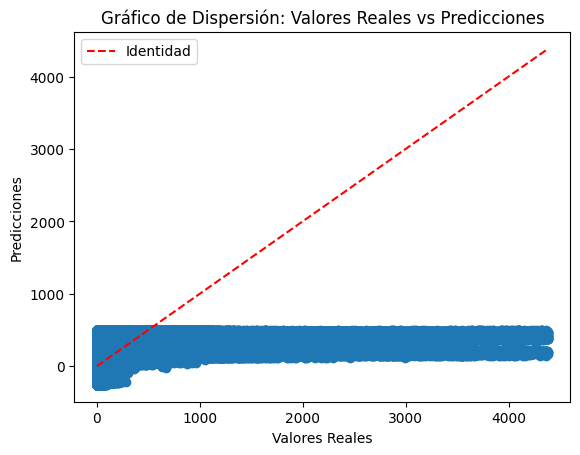

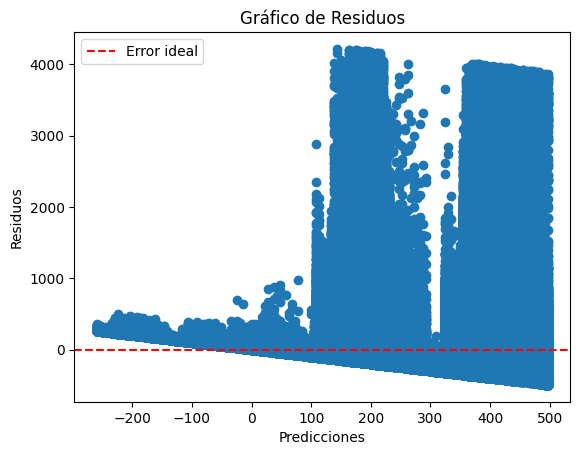

In [16]:
x_train, y_train, x_test, y_test = get_test_train_data('hora', 
                     'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3',
                     dataset=dataset)

# Instanciar el modelo
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

graph_predictions(y_test, y_pred)

Como el error total fue demasiado alto, se decidió probar con distintas combinaciones de las variables predictoras. El modelo que logró el mejor resultado fue el que utilizó todas las variables posibles.

### Regresión lineal múltiple con dataset completo

Error cuadrático medio (MSE): 182478.99471311047
Raíz del Error Cuadrático Medio (RMSE): 427.17560172967563
Error Absoluto Medio (MAE): 239.03969306494787
Coeficiente de Determinación (R²): 0.17916325413432632
Error Absoluto Medio Porcentual (MAPE): 3268.769543804514


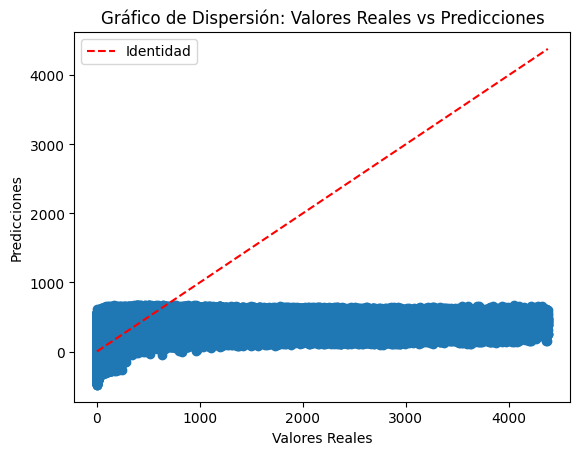

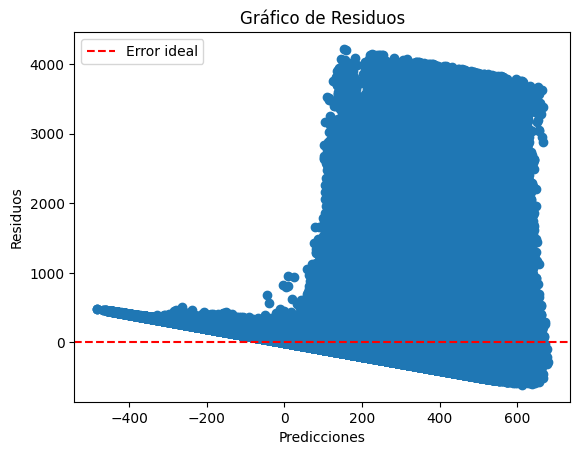

In [17]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)


# Instanciar el modelo
linear_model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

graph_predictions(y_test, y_pred)

## Random forest

Se esperaba que el random forest obtuviera mejores resultados por su capacidad de identificar relaciones no lineales entre las variables.

Error cuadrático medio (MSE): 13224.776380603042
Raíz del Error Cuadrático Medio (RMSE): 114.99902773764238
Error Absoluto Medio (MAE): 36.72981999650285
Coeficiente de Determinación (R²): 0.9405116055898817
Error Absoluto Medio Porcentual (MAPE): 124.70940124677541


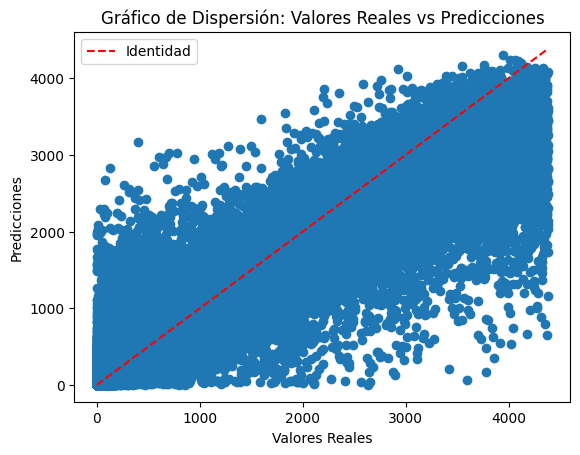

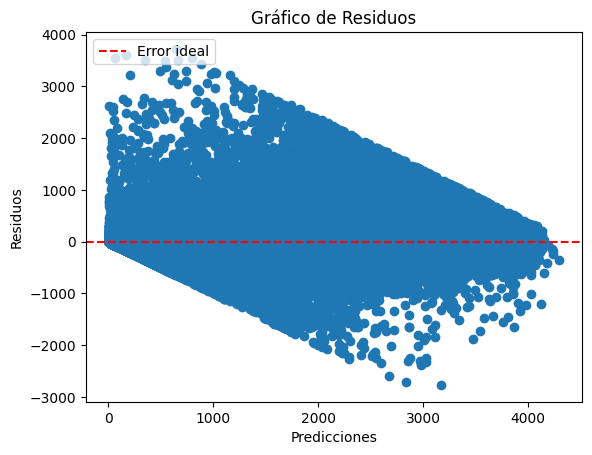

In [18]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

# Instanciar y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=10,
                                 criterion="squared_error",
                                 max_depth=None,
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 max_features=1,
                                 random_state=42)
rf_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(x_test)

graph_predictions(y_test, y_pred_rf)

Se probaron diferentes combinaciones de parámetros para limitar la sensibilidad al ruido y generalizar mejor los datos. Sin embargo, esta parametrización fue la que mejor resultado dio.

## Árbol de decisión

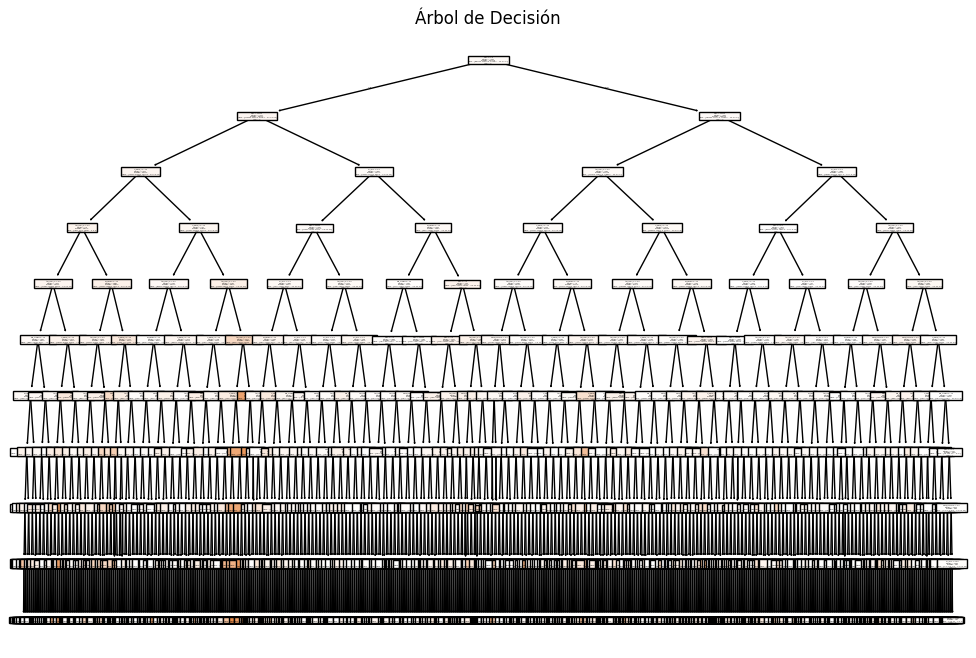

In [5]:
# Seleccionar solo las columnas más relevantes para reducir el uso de memoria
cols1 =['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']  
cols = ['hora', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']
x = dataset[cols1]  
y = dataset['pasos'] 

# Dividir en conjunto de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# Crear objeto clasificador de Decision Tree
clf = DecisionTreeClassifier(
    random_state=42,
    criterion="entropy", 
    max_depth=10,  # Aumentar la profundidad del árbol
    min_samples_split=20,  # Aumentar el número mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=10,  # Aumentar el número mínimo de muestras requeridas en un nodo hoja
    max_features="sqrt"
)

# Entrenar el clasificador de Decision Tree
clf.fit(x_train, y_train)

# Visualizar el árbol de decisión
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=cols1, class_names=y.unique().astype(str), filled=True)
plt.title("Árbol de Decisión")
plt.show()